Total Arrived Customers: 15414
Total Parked Customers: 12294
Total Lost Customers: 3120
Percentage of Lost Customers Due to Full Parking: 0.00%
Percentage of Lost Customers Due to Dissatisfaction with Parking Price: 20.24%
Lost Revenue Due to Full Parking: ₹0.00
Lost Revenue Due to Dissatisfaction with Price: Rs.111619.81


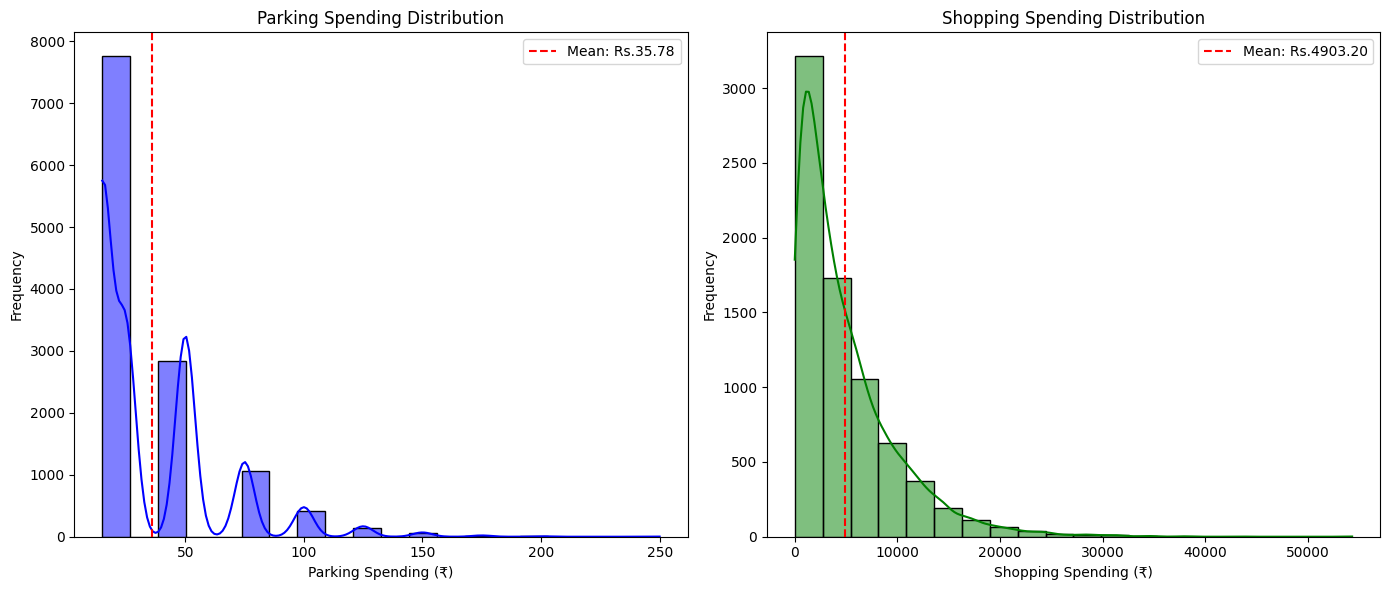

Number of People Spending on Parking: 12294
Number of People Spending on Shopping: 7446
Average Shopping Spending: Rs.4903.20
Total Revenue from Parking: Rs.439825.00
Total Revenue from Shopping: Rs.36509247.60
Total Revenue Lost Due to Parking Full: Rs.0.00
Total Revenue Lost Due to Dissatisfaction with Price: Rs.111619.81


In [10]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Simulation parameters
SIM_DURATION = 30 * 12 * 60  # 30 days, 12 hours per day (8 AM to 8 PM)
CAPACITY = 250
WILLINGNESS_TO_VISIT = 0.80  # 80% willingness to visit

# Arrival rates based on the day of the week and time slots
ARRIVAL_RATES = {
    'Sunday': [(8, 12, 15), (12, 17, 50), (17, 20, 50)],
    'Monday': [(8, 12, 15), (12, 17, 50), (17, 20, 50)],
    'Tuesday': [(8, 12, 15), (12, 17, 50), (17, 20, 50)],
    'Wednesday': [(8, 12, 15), (12, 17, 50), (17, 20, 50)],
    'Thursday': [(8, 12, 15), (12, 17, 50), (17, 20, 50)],
    'Friday': [(8, 12, 20), (12, 17, 70), (17, 20, 80)],
    'Saturday': [(8, 12, 20), (12, 17, 70), (17, 20, 80)]
}

# Initialize data for tracking arrivals, inter-arrival times, parking durations, revenue, and parking space utilization
arrival_pattern = np.zeros((30, 12))  # 30 days, 12 hours per day (8 AM to 8 PM)
inter_arrival_times = [[] for _ in range(30 * 12)]  # List of lists for storing inter-arrival times for each time slot
parking_durations = []  # List to store parking durations
total_revenue_parking = 0  # Total parking revenue accumulator
total_revenue_shopping = 0  # Total shopping revenue accumulator
lost_customers_due_to_price = 0  # Lost customers due to dissatisfaction with price
lost_customers_due_to_full = 0  # Lost customers due to parking lot being full
parked_customers = 0  # Parked customers accumulator
utilization_data = []  # List to store occupancy data for utilization calculation
spending_data = []  # List to store shopping spending

# Spending parameters
mean_spending = 5000  # Mean for the exponential distribution for shopping
lambda_spending = 1 / mean_spending  # Rate parameter for the exponential distribution

def get_arrival_rate(day, hour):
    """Return the arrival rate based on the day and hour."""
    for start, end, rate in ARRIVAL_RATES[day]:
        if start <= hour < end:
            return rate
    return 0

def calculate_charge(parking_duration):
    """Calculate the charge based on parking duration with ceiling logic."""
    if parking_duration < 30:
        return 15
    else:
        hours = np.ceil(parking_duration / 60)  # Round up to the nearest hour
        return 25 * hours  # Charge ₹25 per hour

def vehicle(env, parking_lot, day_index, hour_index, inter_arrival_time):
    """Simulates vehicle parking behavior, tracks arrivals, inter-arrival times, and calculates revenue."""
    global total_revenue_parking, lost_customers_due_to_price, lost_customers_due_to_full, parked_customers, total_revenue_shopping
    
    # Check if the vehicle decides to park based on willingness to visit
    if np.random.random() > WILLINGNESS_TO_VISIT:
        lost_customers_due_to_price += 1
        return  # Vehicle leaves without parking
    
    with parking_lot.request() as request:
        yield request | env.timeout(0)  # Attempt to acquire a parking space

        if not request.triggered:  # If the request was not triggered, parking is full
            lost_customers_due_to_full += 1
            return  # Vehicle leaves without parking

        # Generate parking duration (in minutes)
        parking_duration = np.random.exponential(60)  # Exponential distribution with mean 60 minutes
        parking_durations.append(parking_duration)  # Store parking duration

        # Calculate the parking charge based on parking duration
        charge = calculate_charge(parking_duration)
        total_revenue_parking += charge  # Update total parking revenue
        parked_customers += 1  # Increment parked customers counter

        # Generate shopping spending based on exponential distribution
        if np.random.rand() > 0.4:  # 70% of customers do not shop
            spending = np.random.exponential(scale=mean_spending)
            spending_data.append(spending)
            total_revenue_shopping += spending
        
        yield env.timeout(parking_duration)  # Simulate parking duration

        # Track arrivals for the specific day and hour
        arrival_pattern[day_index, hour_index] += 1
        # Store the inter-arrival time
        inter_arrival_times[day_index * 12 + hour_index].append(inter_arrival_time)

def arrival_process(env, parking_lot, day, day_index):
    """Simulates the arrival process based on the day and time."""
    while env.now < (day_index + 1) * 12 * 60:  # Simulate only 12 hours per day
        current_hour = (env.now // 60) % 12 + 8  # Convert minutes to simulation hour (8 AM - 8 PM)
        rate = get_arrival_rate(day, current_hour)

        # Determine the hour index (0 to 11 for 8 AM to 8 PM)
        hour_index = int(current_hour - 8)  # Adjust index to match 0-11 range

        if 0 <= hour_index < 12:  # Ensure hour_index is within valid bounds
            if rate > 0:
                inter_arrival_time = np.random.exponential(60 / rate)  # Convert hourly rate to inter-arrival time
                yield env.timeout(inter_arrival_time)
                env.process(vehicle(env, parking_lot, day_index, hour_index, inter_arrival_time))
            else:
                yield env.timeout(1)  # Wait for 1 minute if no arrival

def run_simulation():
    """Runs the simulation for 30 days."""
    env = simpy.Environment()
    parking_lot = simpy.Resource(env, capacity=CAPACITY)

    for day_index in range(30):
        day_name = list(ARRIVAL_RATES.keys())[day_index % 7]  # Cycle through days of the week
        env.process(arrival_process(env, parking_lot, day_name, day_index))

        # Simulate 12 hours of the current day
        env.run(until=(day_index + 1) * 12 * 60)

# Run the simulation
run_simulation()

# Calculate total attempted arrivals
total_attempted_arrivals = parked_customers + lost_customers_due_to_price + lost_customers_due_to_full

# Calculate percentage lost due to parking full and dissatisfaction
percentage_lost_due_to_full = (lost_customers_due_to_full / total_attempted_arrivals) * 100 if total_attempted_arrivals > 0 else 0
percentage_lost_due_to_price = (lost_customers_due_to_price / total_attempted_arrivals) * 100 if total_attempted_arrivals > 0 else 0

# Calculate average parking charge for calculating lost revenue
average_parking_charge = np.mean([calculate_charge(d) for d in parking_durations]) if parking_durations else 0

# Calculate lost revenue due to dissatisfaction and full parking
lost_revenue_due_to_price = lost_customers_due_to_price * average_parking_charge
lost_revenue_due_to_full = lost_customers_due_to_full * average_parking_charge

# Print results
print(f"Total Arrived Customers: {total_attempted_arrivals}")
print(f"Total Parked Customers: {parked_customers}")
print(f"Total Lost Customers: {lost_customers_due_to_price + lost_customers_due_to_full}")
print(f"Percentage of Lost Customers Due to Full Parking: {percentage_lost_due_to_full:.2f}%")
print(f"Percentage of Lost Customers Due to Dissatisfaction with Parking Price: {percentage_lost_due_to_price:.2f}%")
print(f"Lost Revenue Due to Full Parking: ₹{lost_revenue_due_to_full:.2f}")
print(f"Lost Revenue Due to Dissatisfaction with Price: Rs.{lost_revenue_due_to_price:.2f}")

# Plot spending on parking and shopping
plt.figure(figsize=(14, 6))

# Plot Parking Spending
plt.subplot(1, 2, 1)
parking_spending = [calculate_charge(d) for d in parking_durations]
sns.histplot(parking_spending, kde=True, bins=20, color='blue', edgecolor='black')
plt.title("Parking Spending Distribution")
plt.xlabel("Parking Spending (₹)")
plt.ylabel("Frequency")
plt.axvline(np.mean(parking_spending), color='red', linestyle='--', label=f'Mean: Rs.{np.mean(parking_spending):.2f}')
plt.legend()

# Plot Shopping Spending
plt.subplot(1, 2, 2)
sns.histplot(spending_data, kde=True, bins=20, color='green', edgecolor='black')
plt.title("Shopping Spending Distribution")
plt.xlabel("Shopping Spending (₹)")
plt.ylabel("Frequency")
plt.axvline(np.mean(spending_data), color='red', linestyle='--', label=f'Mean: Rs.{np.mean(spending_data):.2f}')
plt.legend()

plt.tight_layout()
plt.show()

# Print frequency of people spending on parking and shopping
print(f"Number of People Spending on Parking: {len(parking_spending)}")
print(f"Number of People Spending on Shopping: {len(spending_data)}")
print(f"Average Shopping Spending: Rs.{np.mean(spending_data):.2f}")
print(f"Total Revenue from Parking: Rs.{total_revenue_parking:.2f}")
print(f"Total Revenue from Shopping: Rs.{total_revenue_shopping:.2f}")
print(f"Total Revenue Lost Due to Parking Full: Rs.{lost_revenue_due_to_full:.2f}")
print(f"Total Revenue Lost Due to Dissatisfaction with Price: Rs.{lost_revenue_due_to_price:.2f}")
